<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas y funciones

In [1]:
import numpy as np
import pandas as pd

import itertools

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura y exploración de la Serie de Tiempo

In [3]:
file = 'https://raw.githubusercontent.com/AnIsAsPe/Prediccion-produccion-electricidad/main/Datos/IPG2211A2N%20_2023_01.csv'

datos = pd.read_csv(file,
                    index_col = [0],
                    parse_dates=['DATE']
                    )
datos = datos.loc['2000-01-01':]
datos.columns = ['Producción']  # NAICS 2211

datos

,Producción
DATE,
2000-01-01,100.9623
2000-02-01,93.1065
2000-03-01,87.0234
2000-04-01,80.4433
2000-05-01,83.4549
...,...
2022-09-01,100.4154
2022-10-01,91.0391
2022-11-01,100.8168


## Asegurar el orden y la continuidad de la serie de tiempo

In [ ]:
# La monotonicidad es una propiedad matemática que indica que una función
# determinada mantiene un orden no creciente o decreciente en todo su dominio

datos.index.is_monotonic_increasing

True

In [ ]:
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='DATE', length=277, freq=None)

In [ ]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='DATE', length=277, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

### Ejemplo de Serie discontinua

In [ ]:
df  = datos.drop( [ '2015-09-01', '2019-07-01'])
df

,Producción
DATE,
2000-01-01,100.9623
2000-02-01,93.1065
2000-03-01,87.0234
2000-04-01,80.4433
2000-05-01,83.4549
...,...
2022-09-01,100.4154
2022-10-01,91.0391
2022-11-01,100.8168


In [ ]:
df.index.is_monotonic_increasing

True

In [ ]:
# Cuando flatan dato0s, no es posible inferir la frecuencia
df.index.freq = df.index.inferred_freq
df.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='DATE', length=275, freq=None)

In [ ]:
df.index.min(), df.index.max()

(Timestamp('2000-01-01 00:00:00'), Timestamp('2023-01-01 00:00:00'))

In [ ]:
# Creamos una Series de pandas con las fechas esperadas para compararlo con las
# fechas en nuestra serie de tiempo.

obsEsperadas = pd.Series(data=pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS'))

# Filtramos las fechas, en las obserbvaciones Esperadas que no aparecen en
# nuestra serie de tiempo

faltantes = obsEsperadas[~ obsEsperadas.isin(df.index)]

for i in faltantes.dt.strftime('%Y/%m/%d'):
    print(i)

2015/09/01
2019/07/01


In [5]:
from datetime import  timedelta
from dateutil.relativedelta import relativedelta

end_month =  datos.index.max()
split_month = end_month + relativedelta(months=-12)
split_month

Timestamp('2022-01-01 00:00:00')

# División de la serie en entrenamiento y prueba

In [6]:
train = datos.loc[:split_month,'Producción']
test = datos.loc[split_month + relativedelta(months=1):,'Producción']

## Exploración y Visualización de la Serie Temporal

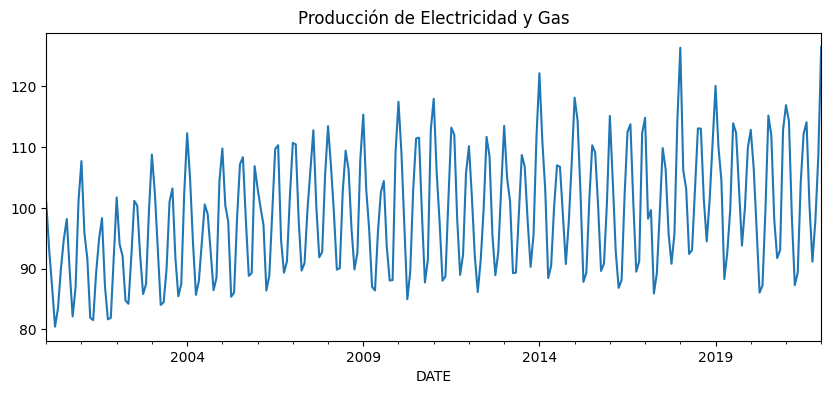

In [ ]:
train.plot(label = 'train', figsize =(10,4), title='Producción de Electricidad y Gas')
plt.show()

**¿Es la serie estacionaria?**



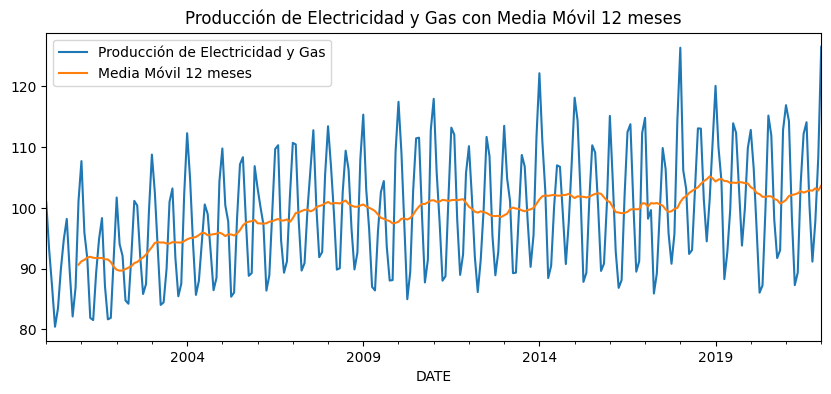

In [ ]:
train.plot(label='Producción de Electricidad y Gas')
train.rolling(12).mean().plot(figsize=(10,4),label='Media Móvil 12 meses')
plt.title('Producción de Electricidad y Gas con Media Móvil 12 meses')
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, temporalidad y residuos.
Esta función nos permite observar la tendencia , la temporalidad, y entender si lo que resta (los residuos) se pueden modelar con un modelo ARMA.

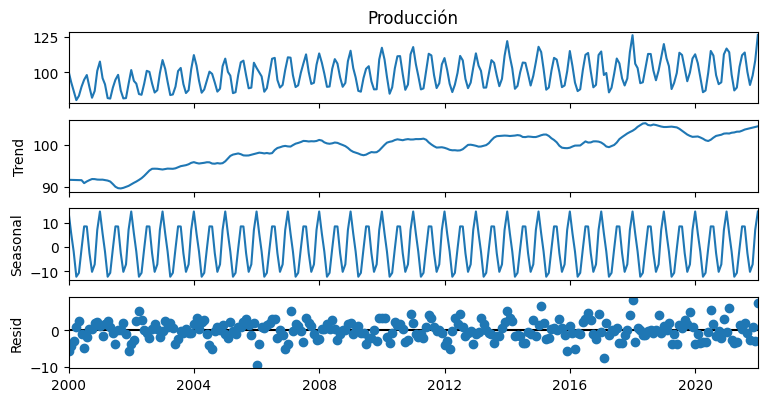

In [ ]:
decomposition = seasonal_decompose(train, model = 'additive',
                            period=12, extrapolate_trend='freq'
                            )
fig =decomposition.plot()
fig.set_size_inches(8,4)

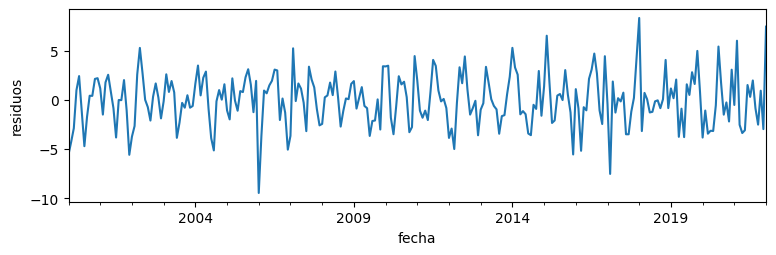

In [ ]:
residuals = decomposition.resid
residuals.plot(figsize=(9,2.5))
plt.ylabel('residuos')
plt.xlabel('fecha')
plt.show()

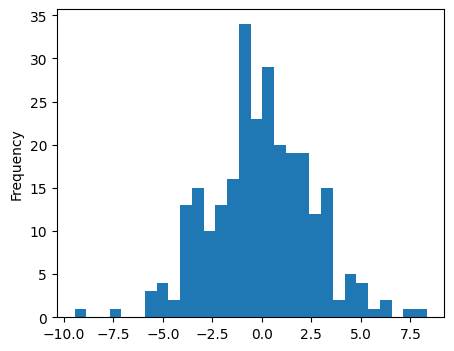

In [ ]:
_ = residuals.plot.hist(figsize=(5,4), bins=30)

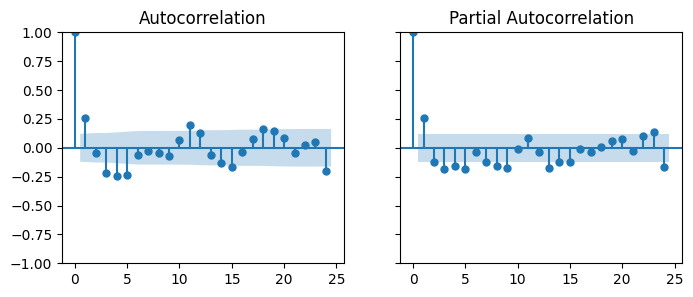

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True)
plot_acf(residuals, lags=24,  ax=axes[0])
plot_pacf(residuals, lags= 24, ax=axes[1])
plt.show()

Observando las gráficas anteriores vemos que existen correlaciones que son significativas en varios retrasos (lags), por lo que pensar en modelar la serie con con un modelo ARMA, es una buena idea.

El modelo SARIMA extiende el modelo ARMA para modelar series temporales con la tendencia y la temporalidad. La componente de temporalidad incorpora terminos AR (autorregresivo), I(Integrado) y MA(Medias Móviles) especificos.

Un modelo SARIMA tiene parametros (`p`, `d`, `q`) x (`P`, `D`, `Q`, `t`)

Lo primero que vamos a hacer es investigar cuantas veces se tiene que diferenciar la serie para hacerla estacionaria, es decir, el parámetro `d`

# Construcción del modelo SARIMA



## Estacionariedad de la Serie (parametro d)


Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [34]:
p_value_adfuller(train)

P-value:  0.5386392168314844
No se rechaza la hipóteis nula, los datos no son estacionarios


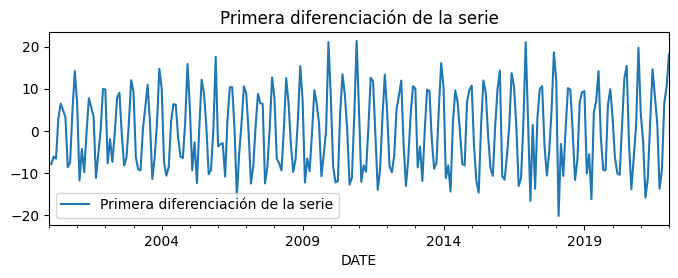

In [35]:
train_1diff = train - train.shift(1)

train_1diff.plot(figsize=(8,2.5), label='Primera diferenciación de la serie')
plt.title('Primera diferenciación de la serie')
plt.legend()
plt.show()

In [36]:
p_value_adfuller(train_1diff.dropna())

P-value:  6.972297949043306e-13
Se rechaza la hipótesis nula, los datos son estacionarios


por tanto el parametro d = 1

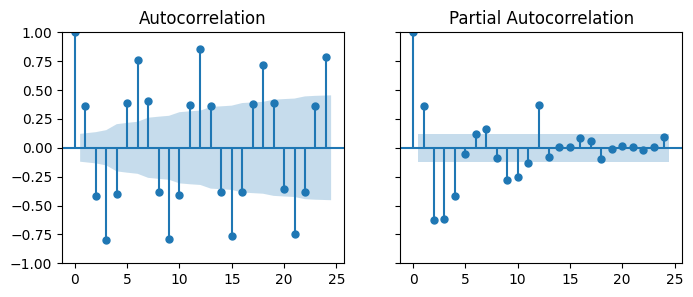

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True)
plot_acf(train_1diff.dropna(), lags=24,  ax=axes[0])
plot_pacf(train_1diff.dropna(), lags= 24, ax=axes[1])
plt.show()

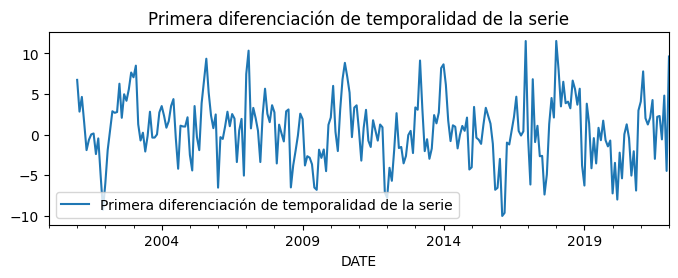

In [38]:
train_12diff = train - train.shift(12)

train_12diff.plot(figsize=(8,2.5), label='Primera diferenciación de temporalidad de la serie')
plt.title('Primera diferenciación de temporalidad de la serie')
plt.legend()
plt.show()

In [39]:
p_value_adfuller(train_12diff.dropna())

P-value:  5.165520409301671e-05
Se rechaza la hipótesis nula, los datos son estacionarios


por tanto los parametros D (ARIMA) y d (en temporalidad) son = 1

## Orden del modelo SARIMA (p, d, q) x (P, D, Q, t)

La biblioteca `pmdarima` tiene una función `auto_arima`, sin embargo la dependencia a otras bibliotecas limita su uso.

In [ ]:
p =  q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [ ]:
P =  Q = range(0, 3)
PDQt = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, [1], Q))]
PDQt

[(0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12)]

En cualquier búsqueda de parámetros, se recomienda comenzar la busqueda haciendo uso de los hallazgos de la exploración y limitar el espacio de busqueda para despues, si es necesario, incrementar gradualmente la búsqueda.

In [ ]:
%%time
from joblib import Parallel, delayed

def fit_sarimax_model(parametros, parametros_s):
      modelo = SARIMAX(train, order=parametros, seasonal_order=parametros_s, enforce_stationarity=False, enforce_invertibility=False)
      results = modelo.fit()
      return (parametros, parametros_s), results.aic

results = Parallel(n_jobs=-1)(delayed(fit_sarimax_model)(parametros, parametros_s) for parametros in pdq for parametros_s in PDQt)
aic_modelos = dict(results)

CPU times: user 408 ms, sys: 103 ms, total: 511 ms
Wall time: 1min 22s


In [ ]:
aic_modelos

{((0, 1, 0), (0, 1, 0, 12)): np.float64(1419.9459736730503),
 ((0, 1, 0), (0, 1, 1, 12)): np.float64(1268.5275057091703),
 ((0, 1, 0), (0, 1, 2, 12)): np.float64(1209.7075023118623),
 ((0, 1, 0), (1, 1, 0, 12)): np.float64(1340.9461673139335),
 ((0, 1, 0), (1, 1, 1, 12)): np.float64(1274.3166899411763),
 ((0, 1, 0), (1, 1, 2, 12)): np.float64(1209.0819323952232),
 ((0, 1, 0), (2, 1, 0, 12)): np.float64(1251.957358483115),
 ((0, 1, 0), (2, 1, 1, 12)): np.float64(1209.09599482121),
 ((0, 1, 0), (2, 1, 2, 12)): np.float64(1206.2626169184662),
 ((0, 1, 1), (0, 1, 0, 12)): np.float64(1374.7007598581972),
 ((0, 1, 1), (0, 1, 1, 12)): np.float64(1220.6591752949112),
 ((0, 1, 1), (0, 1, 2, 12)): np.float64(1162.4399920353276),
 ((0, 1, 1), (1, 1, 0, 12)): np.float64(1302.0781336292398),
 ((0, 1, 1), (1, 1, 1, 12)): np.float64(1227.8109498579734),
 ((0, 1, 1), (1, 1, 2, 12)): np.float64(1159.5014485595489),
 ((0, 1, 1), (2, 1, 0, 12)): np.float64(1204.889344845311),
 ((0, 1, 1), (2, 1, 1, 12)):

El criterio de información de Akaike ([AIC](https://es.wikipedia.org/wiki/Criterio_de_informaci%C3%B3n_de_Akaike)) es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos.

Considera la bondad de ajuste del modelo a los datos, pero también la complejidad del modelo (número de parámetros)

AIC ofrece una estimación relativa de la información perdida cuando se utiliza un modelo determinado para representar el proceso que genera los datos

In [42]:
# modelo = min(aic_modelos, key = aic_modelos.get)
# print('Modelo: ', modelo )
# print('AIC: ',min(aic_modelos.values()))


In [43]:
modelo = SARIMAX(train,
                 order = (1, 1, 2),
                 seasonal_order = (2, 1, 2, 12),
                 enforce_stationarity = False,
                 enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3793      0.216      1.760      0.078      -0.043       0.802
ma.L1         -0.9744      0.228     -4.276      0.000      -1.421      -0.528
ma.L2          0.0434      0.198      0.219      0.827      -0.345       0.432
ar.S.L12       0.1061      0.169      0.628      0.530      -0.225       0.437
ar.S.L24      -0.3806      0.064     -5.906      0.000      -0.507      -0.254
ma.S.L12      -0.8577      0.185     -4.624      0.000      -1.221      -0.494
ma.S.L24       0.0805      0.165      0.489      0.625      -0.242       0.403
sigma2         7.8008      0.764     10.210      0.000       6.303       9.298


## Validación

### Análisis de los residuos del modelo

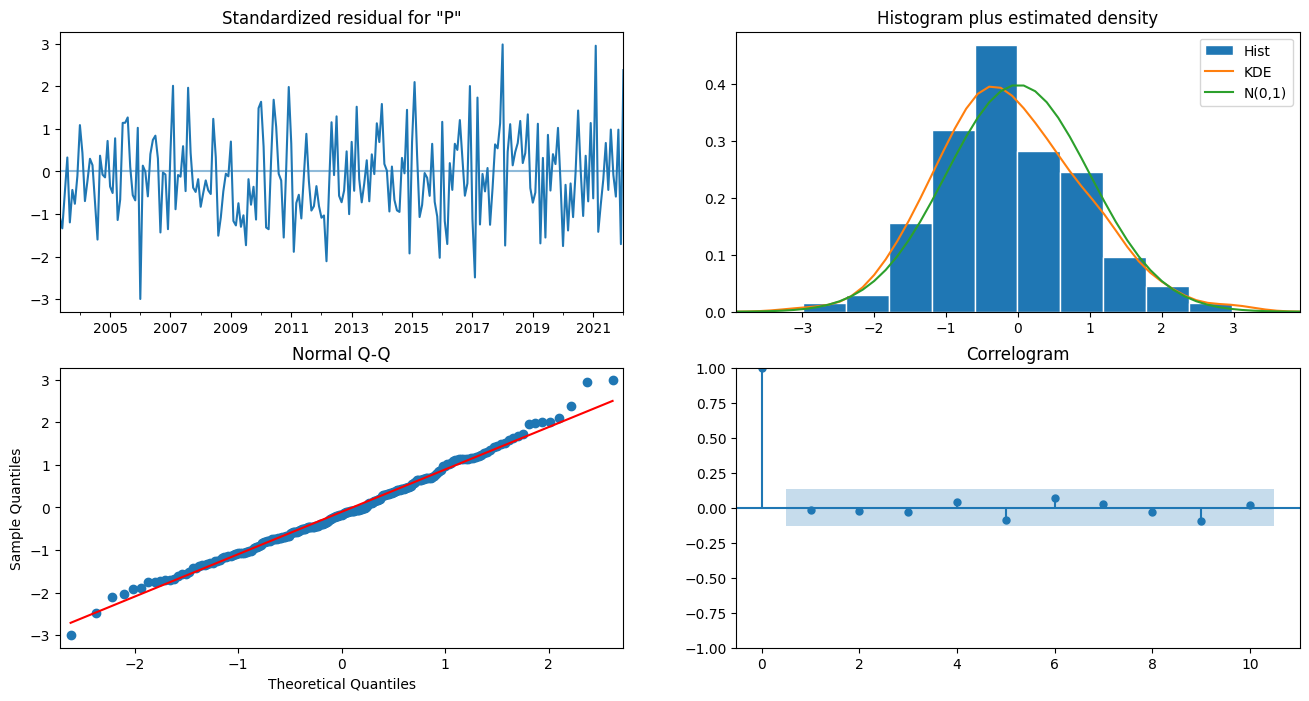

In [44]:
resultados.plot_diagnostics(figsize = (16,8))
plt.show()

###  Predicción y evaluación del modelo

In [45]:
pred = resultados.get_prediction(start = split_month + pd.DateOffset(months=1),
                                 end = end_month)
pred.predicted_mean

,predicted_mean
2022-02-01,112.210893
2022-03-01,103.840180
2022-04-01,91.257367
2022-05-01,93.534912
2022-06-01,104.207357
2022-07-01,113.297840
2022-08-01,113.459992
2022-09-01,102.678002
2022-10-01,93.909648
2022-11-01,99.763030


In [46]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower Producción,upper Producción
2022-02-01,106.736712,117.685074
2022-03-01,97.934245,109.746116
2022-04-01,85.227041,97.287692
2022-05-01,87.446374,99.623451
2022-06-01,98.079128,110.335585
2022-07-01,107.136088,119.459591
2022-08-01,107.267004,119.652980
2022-09-01,96.454712,108.901292
2022-10-01,87.656493,100.162802
2022-11-01,93.480262,106.045798


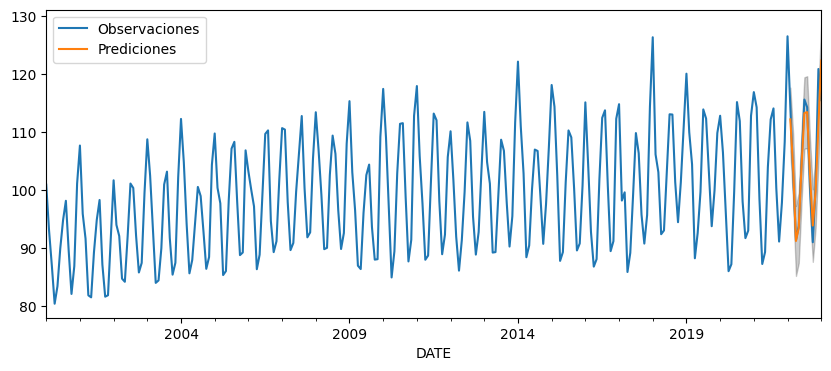

In [47]:
fig = datos.loc[:,'Producción'].plot(label = 'Observaciones',
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index,
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1],
                 color='k', alpha=.2)
plt.legend()
plt.show()

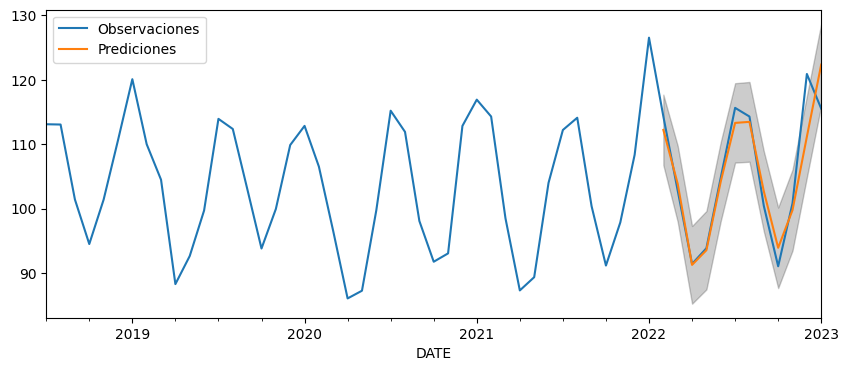

In [48]:
fig = datos.loc['2018-07-01':,'Producción'].plot(label = 'Observaciones',
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index,
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1],
                 color='k', alpha=.2)
plt.legend()
plt.show()

In [49]:
y_pred  = pred.predicted_mean
y_real = datos.loc[split_month:end_month,'Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 14.02
La raiz del error cuadrático medio es 3.74


# Prophet

Prophet es un procedimiento de predicción de datos de series temporales **univariadas** basado en un modelo **aditivo** en el que las tendencias no lineales se ajustan con estacionalidad anual, semanal y diaria, además de efectos de vacaciones.

Su uso es muy recomendable en series temporales con una fuerte estacionalidad y efectos de dias festivos/vacaciones y eventos especiales.

El diseño de Prophet lo hace robusto en casos de valores faltantes y valores atipicos en la serie temporal.



In [7]:
from prophet import Prophet


In [8]:
train

,Producción
DATE,
2000-01-01,100.9623
2000-02-01,93.1065
2000-03-01,87.0234
2000-04-01,80.4433
2000-05-01,83.4549
...,...
2021-09-01,100.3642
2021-10-01,91.1548
2021-11-01,97.8449


In [10]:
train_Prophet = train.reset_index()
train_Prophet.columns = ['ds', 'y']
train_Prophet

,ds,y
0,2000-01-01,100.9623
1,2000-02-01,93.1065
2,2000-03-01,87.0234
3,2000-04-01,80.4433
4,2000-05-01,83.4549
...,...,...
260,2021-09-01,100.3642
261,2021-10-01,91.1548
262,2021-11-01,97.8449
263,2021-12-01,108.3546


In [11]:
train_Prophet = df_Prophet.loc[:(276-12)]


In [12]:
train_Prophet

,ds,y
0,2000-01-01,100.9623
1,2000-02-01,93.1065
2,2000-03-01,87.0234
3,2000-04-01,80.4433
4,2000-05-01,83.4549
...,...,...
260,2021-09-01,100.3642
261,2021-10-01,91.1548
262,2021-11-01,97.8449
263,2021-12-01,108.3546


## Modelo 1

In [13]:
# Entrenamos el modelo
model_prophet = Prophet(yearly_seasonality=True, interval_width=0.95)
model_prophet.fit(train_Prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
# Creamos el datafreme para los datos que queremos predecir
future_data = model_prophet.make_future_dataframe(periods=12, freq='MS')
# Hacemos las predicciones
pred_Prophet = model_prophet.predict(future_data)

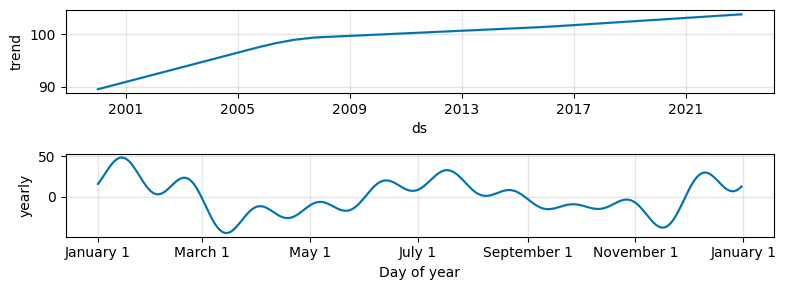

In [22]:
fig = model_prophet.plot_components(fcst=pred_Prophet,   uncertainty=True, figsize = (8,3)   )

In [23]:
pred_Prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,89.563553,97.932114,109.285319,89.563553,89.563553,13.898802,13.898802,13.898802,13.898802,13.898802,13.898802,0.0,0.0,0.0,103.462355
1,2000-02-01,89.681435,90.569741,101.350779,89.681435,89.681435,6.348714,6.348714,6.348714,6.348714,6.348714,6.348714,0.0,0.0,0.0,96.030148
2,2000-03-01,89.791711,80.750137,92.111916,89.791711,89.791711,-3.287065,-3.287065,-3.287065,-3.287065,-3.287065,-3.287065,0.0,0.0,0.0,86.504646
3,2000-04-01,89.909593,72.485210,83.955389,89.909593,89.909593,-11.926906,-11.926906,-11.926906,-11.926906,-11.926906,-11.926906,0.0,0.0,0.0,77.982687
4,2000-05-01,90.023673,74.488494,85.276062,90.023673,90.023673,-10.095579,-10.095579,-10.095579,-10.095579,-10.095579,-10.095579,0.0,0.0,0.0,79.928093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,2022-09-01,103.646366,95.830068,107.215900,103.599741,103.703146,-2.207646,-2.207646,-2.207646,-2.207646,-2.207646,-2.207646,0.0,0.0,0.0,101.438720
273,2022-10-01,103.674399,88.364598,98.757459,103.618428,103.739995,-10.098459,-10.098459,-10.098459,-10.098459,-10.098459,-10.098459,0.0,0.0,0.0,93.575941
274,2022-11-01,103.703367,90.993611,102.044334,103.636058,103.780412,-6.866558,-6.866558,-6.866558,-6.866558,-6.866558,-6.866558,0.0,0.0,0.0,96.836809
275,2022-12-01,103.731401,104.626891,115.761706,103.654967,103.817496,6.525123,6.525123,6.525123,6.525123,6.525123,6.525123,0.0,0.0,0.0,110.256524


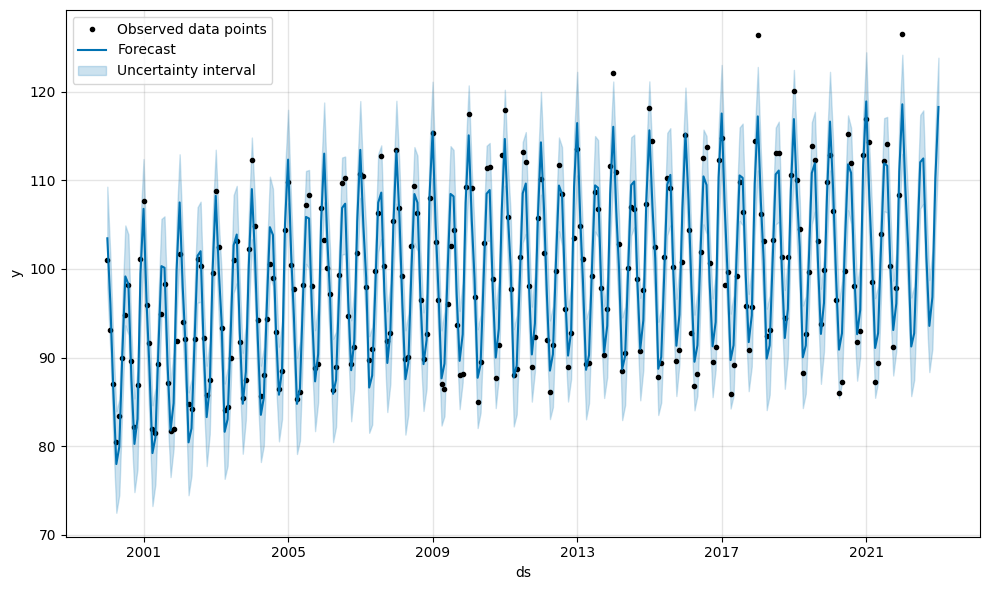

In [24]:
# Visualizamos la predicción
fig = model_prophet.plot(pred_Prophet, include_legend= True)


In [25]:
pred_Prophet.set_index('ds', inplace = True)
inicio_pred = '2022-02-01'
pred_Prophet.loc[inicio_pred:, 'yhat']
y_pred  = pred_Prophet.loc[inicio_pred:,'yhat']
y_real = datos.loc[inicio_pred:,'Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 16.24
La raiz del error cuadrático medio es 4.03


## Modelo 2 considerando periodos de recesión

In [26]:
# Creamos un dataframe con los periodos de recensión

recession_periods = pd.DataFrame([
    {'holiday':'economic_recession_1', 'ds':'2001-03-01', 'lower_window':0, 'ds_upper':'2001-11-01'},
    {'holiday':'economic_recession_2', 'ds':'2007-12-01', 'lower_window':0, 'ds_upper':'2009-06-01'},
    {'holiday':'economic_recession_3', 'ds':'2020-02-01', 'lower_window':0, 'ds_upper':'2020-04-01'},
])


recession_periods['ds'] = pd.to_datetime(recession_periods['ds'])
recession_periods['ds_upper'] = pd.to_datetime(recession_periods['ds_upper'])

year_diff = recession_periods['ds_upper'].dt.year - recession_periods['ds'].dt.year
month_diff = recession_periods['ds_upper'].dt.month - recession_periods['ds'].dt.month

recession_periods['upper_window'] = year_diff * 12 + month_diff
recession_periods

,holiday,ds,lower_window,ds_upper,upper_window
0,economic_recession_1,2001-03-01,0,2001-11-01,8
1,economic_recession_2,2007-12-01,0,2009-06-01,18
2,economic_recession_3,2020-02-01,0,2020-04-01,2


In [27]:
model_prophet2 = Prophet(yearly_seasonality=True,
                         interval_width=0.95,
                         holidays=recession_periods  )
model_prophet2.fit(train_Prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
# Creamos el datafreme para los datos que queremos predecir
future_data2 = model_prophet2.make_future_dataframe(periods=12, freq='MS')
pred_Prophet2 = model_prophet2.predict(future_data2)

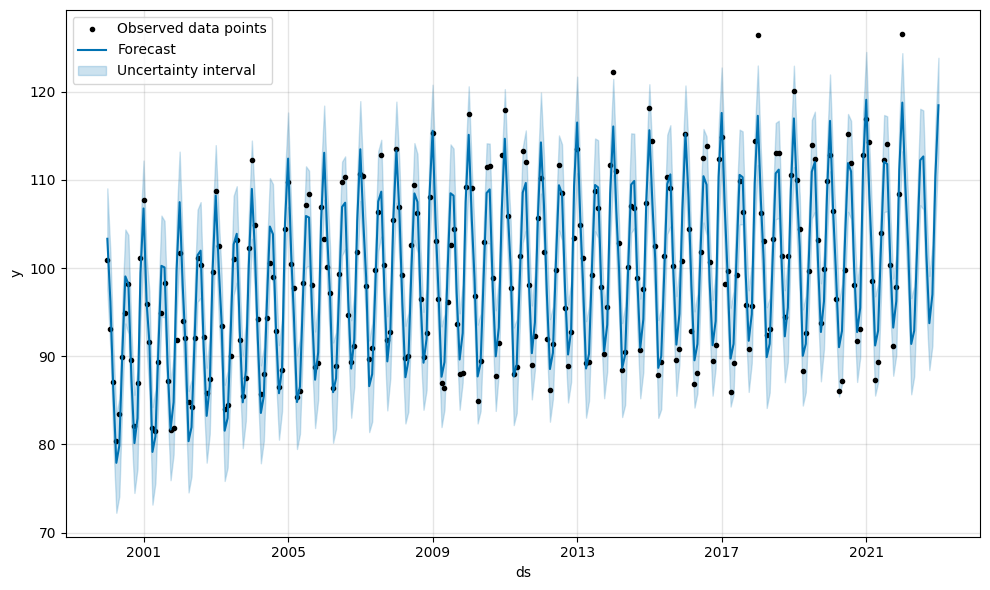

In [29]:
fig2 = model_prophet2.plot(pred_Prophet2, include_legend= True, )

In [30]:
pred_Prophet2.set_index('ds', inplace = True)
inicio_pred = '2022-02-01'
pred_Prophet2.loc[inicio_pred:, 'yhat']

,yhat
ds,
2022-02-01,109.210006
2022-03-01,102.439601
2022-04-01,91.394241
2022-05-01,92.894396
2022-06-01,102.772621
2022-07-01,112.221177
2022-08-01,112.643688
2022-09-01,101.606572
2022-10-01,93.745065


In [31]:
int_conf_Prophet2 = pred_Prophet[[ 'yhat_lower', 'yhat_upper']]
int_conf_Prophet2.iloc[-12:]

,yhat_lower,yhat_upper
ds,,
2022-02-01,103.090172,114.367704
2022-03-01,96.609957,107.934634
2022-04-01,85.651634,96.785676
2022-05-01,87.465262,98.042983
2022-06-01,96.911607,108.016037
2022-07-01,106.819021,117.381887
2022-08-01,107.342226,117.900385
2022-09-01,95.830068,107.215900
2022-10-01,88.364598,98.757459


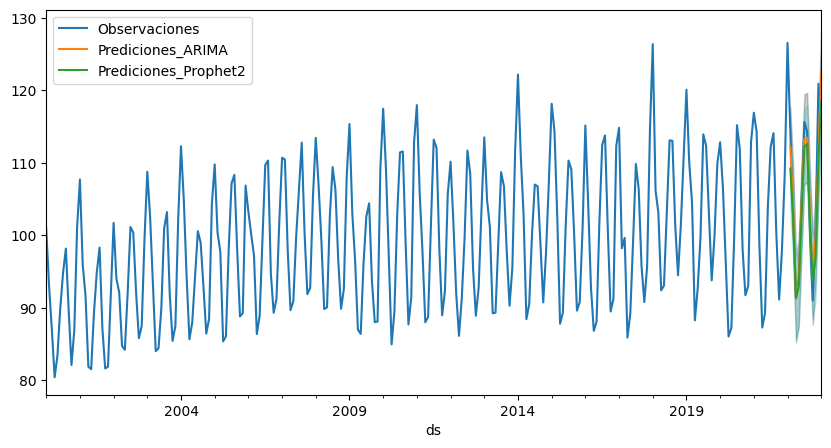

In [50]:
fig = datos.loc[:,'Producción'].plot(label = 'Observaciones',
                                     figsize =(10,5))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones_ARIMA')
fig.fill_between(pred_IC.index,
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1],
                 color='k', alpha=.2)
pred_Prophet2.loc[inicio_pred:,'yhat'].plot(ax = fig, label = 'Prediciones_Prophet2')
fig.fill_between(int_conf_Prophet2.iloc[-12:].index,
                 int_conf_Prophet2.iloc[-12:,0], int_conf_Prophet2.iloc[-12:,1],
                 color='c', alpha=.2)
plt.legend()
plt.show()

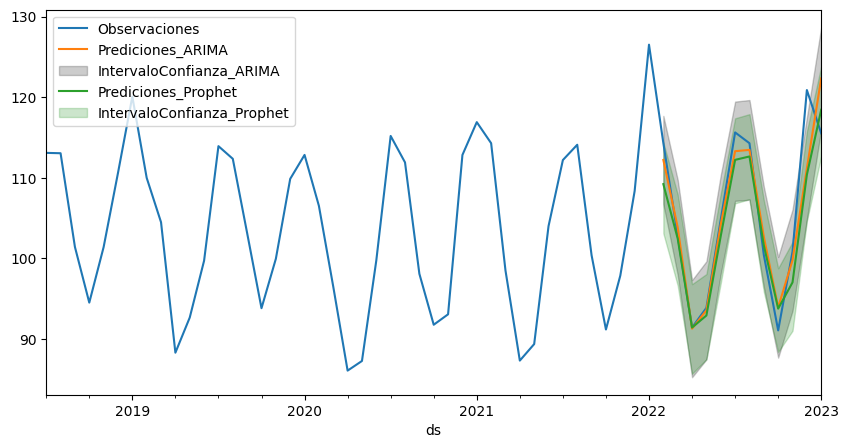

In [51]:
fig = datos.loc['2018-07-01':,'Producción'].plot(label = 'Observaciones',
                                                 figsize =(10,5))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones_ARIMA')
fig.fill_between(pred_IC.index,
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1],
                 color='k', alpha=.2, label='IntervaloConfianza_ARIMA')

pred_Prophet2.loc[inicio_pred:,'yhat'].plot(ax = fig, label = 'Prediciones_Prophet')
fig.fill_between(int_conf_Prophet2.iloc[-12:].index,
                 int_conf_Prophet2.iloc[-12:,0], int_conf_Prophet2.iloc[-12:,1],
                 color='g', alpha=.2, label='IntervaloConfianza_Prophet')
plt.legend()
plt.show()

In [52]:
y_pred  = pred_Prophet2.loc[inicio_pred:,'yhat']
y_real = datos.loc[inicio_pred:end_month,'Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 15.67
La raiz del error cuadrático medio es 3.96
